# Sampling Distributions

This notebook has the plots and code to support the sampling, confidence, and boostrap lecture.

## Setup

Python modules:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

Set up a random number generator:

In [2]:
rng = np.random.default_rng(20200912)

Load the Penguin data:

In [3]:
penguins = pd.read_csv('../penguins.csv')

And we're going to want to look at just the chinstraps sometimes:

In [4]:
chinstraps = penguins[penguins['species'] == 'Chinstrap']
chinstraps.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
276,Chinstrap,Dream,46.5,17.9,192.0,3500.0,female,2007
277,Chinstrap,Dream,50.0,19.5,196.0,3900.0,male,2007
278,Chinstrap,Dream,51.3,19.2,193.0,3650.0,male,2007
279,Chinstrap,Dream,45.4,18.7,188.0,3525.0,female,2007
280,Chinstrap,Dream,52.7,19.8,197.0,3725.0,male,2007


That's all we need this time!

## Sampling Distributions

Let's say we have a population that is accurately described by the normal distribution $\mathrm{Normal(50, 5)}$ — the population mean $\mu = 50$ and its standard deviation $\sigma = 5$, and it's normal.

We can draw a sample of size 50 from this distribution:

In [5]:
dist = sps.norm(50, 5)

In [6]:
sample = dist.rvs(size=50, random_state=rng)

And show its distribution:

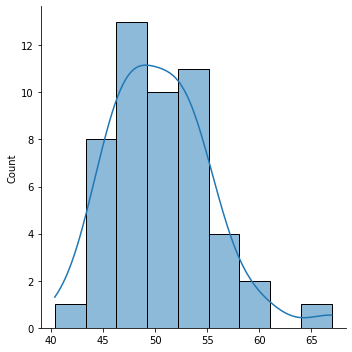

In [7]:
sns.displot(sample, kde=True)

> **Note:** The curve in a Seaborn `distplot` is the *kernel density estimate*: it is an estimate of the probability density function.

We can also compute statistics, such as the mean:

In [8]:
np.mean(sample)

50.462609949153304

That mean is pretty close to our true population mean of 50!  But it isn't quite exact - any given sample is going to have some error.  There is natural variation in samples that affects the statistic.

But what if we did this 1000 times? And each time, we took another sample of 100, and computed its mean?

How would this sample of sample means be distributed?

> **Note:** The syntax `[expr for var in iterable]` is a *list comprehension*. It lets is quickly write lists based on loops.

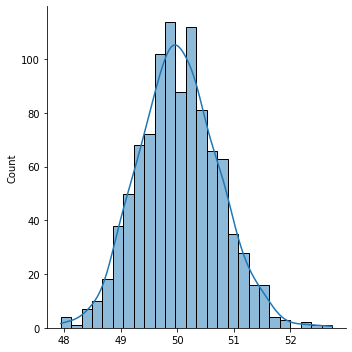

In [9]:
sample_means = [np.mean(dist.rvs(size=50, random_state=rng)) for i in range(1000)]
sns.displot(sample_means, kde=True)

We call this distribution the **sampling distribution** of a statistic.

Let's overlay these on top of each other:

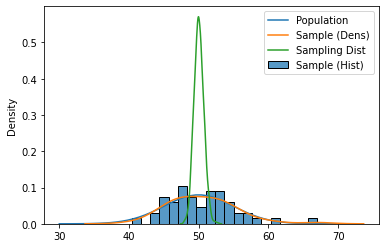

In [10]:
plt.plot(np.linspace(30, 70), dist.pdf(np.linspace(30, 70)), label='Population')
sns.histplot(sample, label='Sample (Hist)', stat='density', bins=20)
sns.kdeplot(sample, label='Sample (Dens)')
sns.kdeplot(sample_means, label='Sampling Dist')
plt.legend()
plt.show()

The sample mean is normally distributed with mean $\mu$ and standard deviation $\sigma/\sqrt{n}$.  Let's see that for a few sample sizes, with the true mean plotted as a vertical line:

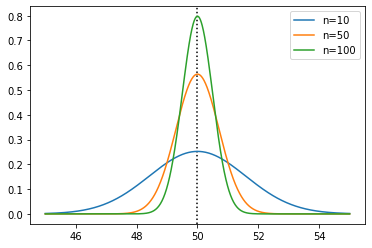

In [11]:
xs = np.linspace(45, 55, 1000)
plt.axvline(50, color='black', linestyle=':')
plt.plot(xs, sps.norm(50, 5 / np.sqrt(10)).pdf(xs), label='n=10')
plt.plot(xs, sps.norm(50, 5 / np.sqrt(50)).pdf(xs), label='n=50')
plt.plot(xs, sps.norm(50, 5 / np.sqrt(100)).pdf(xs), label='n=100')
plt.legend()
plt.show()

### Confidence Intervals

I'm going to write a little function for computing confidence intervals.  It will return a (low, high) tuple.

In [12]:
def ci95(mean, sd, n, width=1.96):
    se = sd / np.sqrt(n)
    off = se * width
    return mean - off, mean + off

What's the estimated CI from our sample?

> **Note:** `ddof=1` tells NumPy's [`std`](https://numpy.org/doc/stable/reference/generated/numpy.std.html) function to compute the sample standard deviation.

In [13]:
ci95(np.mean(sample), np.std(sample, ddof=1), 50)

(49.113141238970556, 51.81207865933605)

Remember from the video and [Confidence in Confidence](https://medium.com/@EpiEllie/having-confidence-in-confidence-intervals-8f881712d837).

What's the range of the middle 95% if we do it a thousand times?  Since we can, of course!

In [14]:
def samp_ci(size=50):
    sample = dist.rvs(size=size, random_state=rng)
    mean = np.mean(sample)
    std = np.std(sample, ddof=1)
    return ci95(mean, std, size)

We're going to use this function with another trick for building Pandas data frames — the `from_records` function, to build from an iterable of rows.  This will give us 1000 intervals:

In [15]:
samp_cis = pd.DataFrame.from_records(
    [samp_ci() for i in range(1000)],
    columns=['lo', 'hi']
)
samp_cis

,lo,hi
0,48.460558,51.501088
1,49.713563,53.065665
2,47.943036,50.575633
3,48.858734,51.382044
4,48.087636,50.666545
...,...,...
995,48.148537,50.703322
996,48.171565,50.644276
997,48.252690,50.419871
998,48.022458,50.543743


Mark the samples where it contains the true mean of 50, and see what fraction there are:

In [16]:
samp_cis['hit'] = (samp_cis['lo'] <= 50) & (samp_cis['hi'] >= 50)
samp_cis.mean()

lo     48.604607
hi     51.358654
hit     0.940000
dtype: float64

94% of our confindence intervals contain the mean. That is quite close to 95%.

> **Practice:** we can treat 'confidence interval contains the true mean' as an event with 95% probability of success.  What distribution describes the number of expected successess for 1000 trials at 95% success?  What is the probability that we would see a value in the range $950 \pm 10$ for such a set of trials?